# **Codig Dojo**: Proyecto 2, predicción de probabilidad de matriculación.
## Creado por: Alejandro Acosta

- Fecha de creación: 2022-02-22
- Fecha de modificación: 2022-03-02
- Descripción: En base a ciertas características de postulantes a una universidad privada de Ecuador, se estima la probabilidad de matriculación de un estudiante universitario de pregrado y cuáles son los factores más importantes que influyen en dicha matriculación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels import OLS

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import DBSCAN

# sns.set()
# plt.style.use('seaborn')
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.dpi'] = 100

## Importación y limpieza de datos

In [2]:
df = pd.read_csv('alumnos.csv')
df.head()

,id_oportunidad,id_estudiante,programa,etapa,fecha_afluencia,fecha_ganado,fecha_perdido,consultor,edad,estado_civil,ciudad,provincia,trabaja,colegio,tipo_admision,origen,enteraste
0,0068W00000RtT5E,-7959495189833833808,1P714,Cerrada Perdida,2022-01-20 00:00:00,NaN,2022-02-11 00:00:00,36,25.0,Casado/a,QUITO,PICHINCHA,Si,1978,Normal,Whatsapp,Recomendado
1,0068W00000RulbV,8433271449132097132,1P734,Cerrada Perdida,2022-02-02 00:00:00,NaN,2022-02-02 00:00:00,8,21.0,NaN,QUITO,PICHINCHA,NaN,1002,Normal,Simulador Homologación,NaN
2,0061U00000NB058,681923597971309571,1P614,Cerrada Perdida,2021-07-22 00:00:00,NaN,2021-07-28 00:00:00,15,19.0,NaN,QUITO,PICHINCHA,No,18,Normal,Colegios,Mi colegio
3,0061U00000NjOPF,-1854769890286518797,1H003,Cerrada Perdida,2021-09-03 00:00:00,NaN,2021-10-06 00:00:00,15,36.0,Casado/a,CHONE,MANABI,Si,1905,Convalidado,Llamada,Redes sociales
4,0061U00000Mm1LY,5707294226770007228,1P244,Cerrada Perdida,2021-06-10 00:00:00,NaN,2021-07-29 00:00:00,16,25.0,Soltero/a,QUITO,PICHINCHA,No,94,Convalidado,Simulador Homologación,Aplicaciones


In [3]:
df = pd.read_csv('alumnos.csv')

# me enfocaré en la cartera cerrada:
df = df[df.etapa.str.startswith('Cerrada')]

# limpieza de variables
df['etapa'] = df.etapa.map({'Cerrada Perdida':'perdida', 'Cerrada Ganada':'ganada'})
df['fecha_afluencia'] = df['fecha_afluencia'].astype('datetime64')
df['fecha_ganado'] = np.where(df.etapa=='ganada', df.fecha_ganado, df.fecha_perdido).astype('datetime64')
df['fecha_perdido'] = (df.fecha_ganado - df.fecha_afluencia).dt.days
df.rename(columns={'fecha_ganado':'fecha_cierre','fecha_perdido':'ciclo'} , inplace=True)
df['afl'] = 1
df['doc'] = np.where(df.etapa=='ganada',1,0)

df.head()

,id_oportunidad,id_estudiante,programa,etapa,fecha_afluencia,fecha_cierre,ciclo,consultor,edad,estado_civil,ciudad,provincia,trabaja,colegio,tipo_admision,origen,enteraste,afl,doc
0,0068W00000RtT5E,-7959495189833833808,1P714,perdida,2022-01-20,2022-02-11,22,36,25.0,Casado/a,QUITO,PICHINCHA,Si,1978,Normal,Whatsapp,Recomendado,1,0
1,0068W00000RulbV,8433271449132097132,1P734,perdida,2022-02-02,2022-02-02,0,8,21.0,NaN,QUITO,PICHINCHA,NaN,1002,Normal,Simulador Homologación,NaN,1,0
2,0061U00000NB058,681923597971309571,1P614,perdida,2021-07-22,2021-07-28,6,15,19.0,NaN,QUITO,PICHINCHA,No,18,Normal,Colegios,Mi colegio,1,0
3,0061U00000NjOPF,-1854769890286518797,1H003,perdida,2021-09-03,2021-10-06,33,15,36.0,Casado/a,CHONE,MANABI,Si,1905,Convalidado,Llamada,Redes sociales,1,0
4,0061U00000Mm1LY,5707294226770007228,1P244,perdida,2021-06-10,2021-07-29,49,16,25.0,Soltero/a,QUITO,PICHINCHA,No,94,Convalidado,Simulador Homologación,Aplicaciones,1,0


In [4]:
df.describe()
# valores negativos en la edad

,id_estudiante,ciclo,consultor,edad,colegio,afl,doc
count,1.305800e+04,13058.000000,13058.000000,12629.000000,13058.000000,13058.0,13058.000000
mean,5.311637e+16,34.492495,22.232271,20.870932,934.404503,1.0,0.221244
std,5.340126e+18,33.693563,11.010521,10.481660,572.181514,0.0,0.415100
min,-9.221462e+18,0.000000,0.000000,-963.000000,-1.000000,1.0,0.000000
25%,-4.578663e+18,8.000000,13.000000,18.000000,470.000000,1.0,0.000000
50%,2.139928e+16,25.000000,22.000000,19.000000,897.500000,1.0,0.000000
75%,4.706171e+18,51.000000,34.000000,22.000000,1407.000000,1.0,0.000000
max,9.221844e+18,222.000000,38.000000,122.000000,1994.000000,1.0,1.000000


In [5]:
df['edad'] = np.where(df.edad < 0, np.nan, df.edad)
df['edad'] = np.where(df.edad < 16, 16, df.edad)
df['edad'] = np.where(df.edad > 40, 40, df.edad)


### Valores perdidos

In [6]:
df.isna().sum()/df.shape[0]

id_oportunidad     0.000000
id_estudiante      0.000000
programa           0.000000
etapa              0.000000
fecha_afluencia    0.000000
fecha_cierre       0.000000
ciclo              0.000000
consultor          0.000000
edad               0.033083
estado_civil       0.117170
ciudad             0.038597
provincia          0.030862
trabaja            0.079568
colegio            0.000000
tipo_admision      0.000000
origen             0.252642
enteraste          0.086690
afl                0.000000
doc                0.000000
dtype: float64

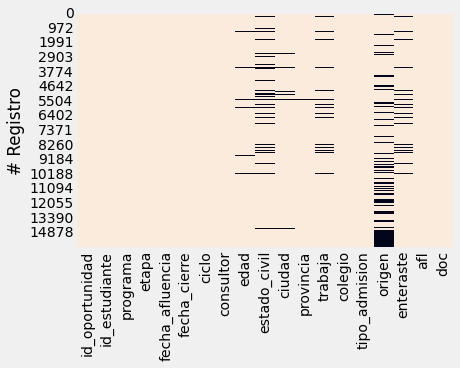

In [7]:
sns.heatmap(~df.isna(), cbar=False)
plt.ylabel('# Registro')
plt.savefig('./images/missings.png', dpi=200, bbox_inches='tight')
plt.show()

- Los valores perdidos en el origen del candidato son imposibles de imputar y su ausencia de valor no representa nada. Este campo se llena automáticamente mediante una interfaz del CRM. Se eliminará esta variable.
- Por otro lado, los valores perdidos de variables que se preguntan al candidato como: su estado civil, edad, ciudad de residencia, estatus labora y ¿cómo te enteraste de la universidad?; nos pueden dar información acerca del interés del candidato en la oferta académica. Un postulante con poco interés puede no estar dispuesto a entregar esta información.

### Imputación

In [8]:
df.drop('origen', axis=1, inplace=True)
df.dropna(subset='edad', inplace=True)
df['edad'] = df.edad.astype('int')

In [9]:
# Tras eliminar la variable origen, se calcula el porcentaje de registros que requieren imputación 
print('Registros con valores perdidos:',f"{1-df.dropna().shape[0]/df.shape[0]:.2%}")

Registros con valores perdidos: 9.32%


In [10]:
var_imputacion = df.isna().sum()[df.isna().sum()>0].index
value_imputacion = 'Sin información'

In [11]:
df.isna().sum()[df.isna().sum()>0]

estado_civil    1128
ciudad           346
provincia        273
trabaja          711
enteraste        765
dtype: int64

In [12]:
# La edad se imputa con 0 y el resto con "Sin Información"
df.fillna(value_imputacion, inplace=True)

In [13]:
df.shape

(12626, 18)

## Estadística descriptiva

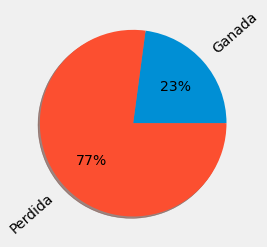

In [14]:
dft = pd.crosstab(df.etapa, df.afl)

plt.pie(dft[1], labels=[i.title() for i in dft.index],
        autopct='%.0f%%', shadow=True, rotatelabels='true')
plt.savefig('./images/conversion.png', dpi=200, bbox_inches='tight')
plt.show()


In [15]:
# conversión
print('Tasa de conversión:',f"{df.doc.mean():.2%}")

Tasa de conversión: 22.88%


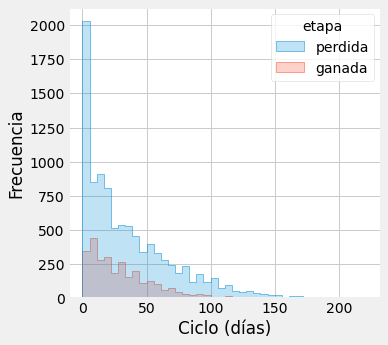

In [44]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='ciclo', hue='etapa', bins=40, element='step')
plt.xlabel('Ciclo (días)')
plt.ylabel('Frecuencia')
plt.savefig('./images/ciclo-histograma.png', dpi=200, bbox_inches='tight')
plt.show()

Un ciclo muy corto sugiere una baja probabilidad de matricularse

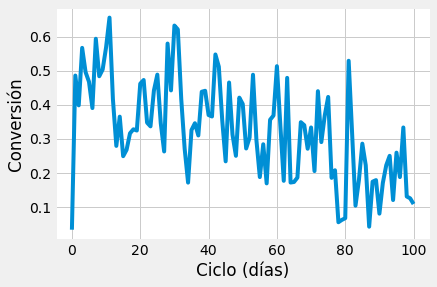

In [17]:
conv = pd.crosstab(index=np.where(df.ciclo>100,100,df.ciclo), columns=df.etapa)
conv['ratio'] = conv['ganada']/conv['perdida']
conv['ratio'].plot()
plt.xlabel('Ciclo (días)')
plt.ylabel('Conversión')
# plt.savefig('./images/ciclo-conversion.png', dpi=200, bbox_inches='tight')
plt.show()

In [18]:
conv.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
             91,  92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64', name='row_0', length=101)

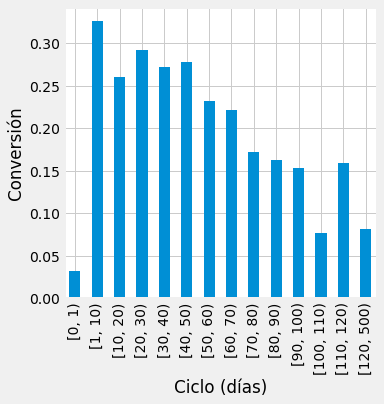

In [19]:
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 500]
xticks = pd.cut(df.ciclo, bins, right=False).cat.categories
groups = df.groupby(pd.cut(df.ciclo, bins, right=False))
conv = groups[['afl', 'doc']].sum()
# conv.plot(kind='bar')
conv['ratio'] = conv['doc']/conv['afl']

plt.figure(figsize=(5,5))
conv['ratio'].plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Ciclo (días)')
plt.ylabel('Conversión')
plt.savefig('./images/conversion-ciclo.png', dpi=200, bbox_inches='tight')
plt.show()


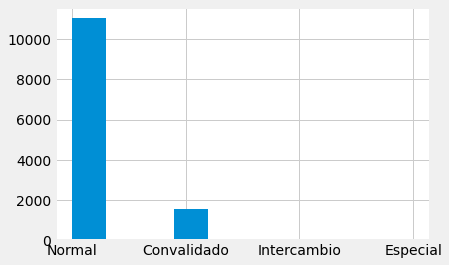

In [20]:
df.tipo_admision.hist()
plt.savefig('./images/tipo_admision.png', dpi=200, bbox_inches='tight')
plt.show()

muy pocas observaciones de intercambio y especial, se eliminan las variables

In [21]:
df = df[~df.tipo_admision.isin(['Intercambio','Especial'])]

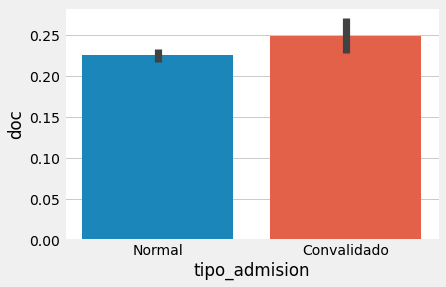

In [22]:
sns.barplot(data=df, x='tipo_admision', y='doc')
plt.savefig('./images/conversion-tipo_admision.png', dpi=200, bbox_inches='tight')
plt.show()

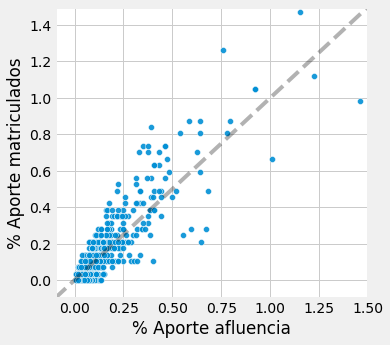

In [23]:
dft = df.pivot_table(index='colegio', values=['afl','doc'], aggfunc=np.sum).drop(-1)

dft['afl'] = dft['afl']/dft['afl'].sum()
dft['doc'] = dft['doc']/dft['doc'].sum()

plt.figure(figsize=(5,5))
sns.scatterplot(x=dft.afl*100, y=dft.doc*100, alpha=0.9)
plt.xlim(-0.1,1.5)
plt.ylim(-0.1,1.5)

plt.xlabel(r'% Aporte afluencia')
plt.ylabel(r'% Aporte matriculados')
plt.axline((0, 0), slope=1, color="black", linestyle='--', alpha=0.3)
plt.savefig('./images/colegios.png', dpi=200, bbox_inches='tight')
plt.show()

Se observa una fuerte correlación entre la cantidad de afluencias y matriculados en los colegios. Es posible clusterizar a los colegios.

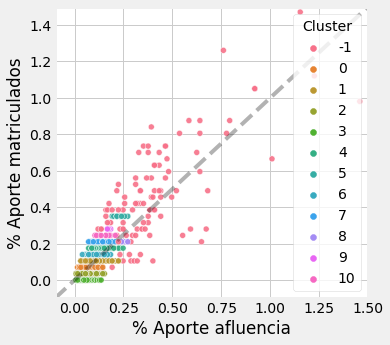

In [24]:

scaler = StandardScaler()
x1 = scaler.fit_transform(dft[['afl', 'doc']])
dbs = DBSCAN(eps=0.25, min_samples=5).fit(x1)
dft['Cluster'] = dbs.labels_
dft['Cluster'] = dft['Cluster'].astype('category')


plt.figure(figsize=(5, 5))
sns.scatterplot(x=dft.afl*100, y=dft.doc*100, hue=dft.Cluster, alpha=0.9)
plt.xlim(-0.1, 1.5)
plt.ylim(-0.1, 1.5)

plt.xlabel(r'% Aporte afluencia')
plt.ylabel(r'% Aporte matriculados')
plt.axline((0, 0), slope=1, color="black", linestyle='--', alpha=0.3)
plt.savefig('./images/colegios-cluster.png', dpi=200, bbox_inches='tight')
plt.show()


In [25]:
df = df.merge(dft.reset_index()[['colegio','Cluster']],how='left',on='colegio')

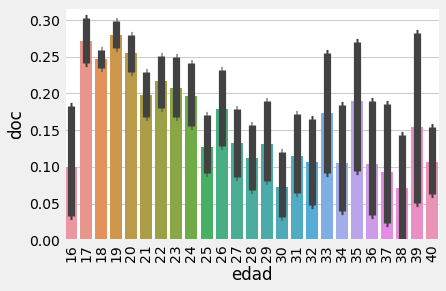

In [26]:
sns.barplot(data=df, x='edad', y='doc',capsize=.1)
plt.xticks(rotation=90)
plt.show()

## Modelo

In [27]:
df.columns

Index(['id_oportunidad', 'id_estudiante', 'programa', 'etapa',
       'fecha_afluencia', 'fecha_cierre', 'ciclo', 'consultor', 'edad',
       'estado_civil', 'ciudad', 'provincia', 'trabaja', 'colegio',
       'tipo_admision', 'enteraste', 'afl', 'doc', 'Cluster'],
      dtype='object')

In [28]:
df.dtypes

id_oportunidad             object
id_estudiante               int64
programa                   object
etapa                      object
fecha_afluencia    datetime64[ns]
fecha_cierre       datetime64[ns]
ciclo                       int64
consultor                   int64
edad                        int32
estado_civil               object
ciudad                     object
provincia                  object
trabaja                    object
colegio                     int64
tipo_admision              object
enteraste                  object
afl                         int64
doc                         int32
Cluster                  category
dtype: object

In [29]:
# Primero necesitamos factorizar todas las variables categóricas y reescalar todas las variables numéricas, para ello se utilizará el método LabelEncoder

cat_vars = ['programa',  'consultor',  'estado_civil', 'provincia',
            'trabaja', 'colegio', 'tipo_admision', 'enteraste', 'Cluster']
num_vars = ['ciclo', 'edad']

le_dict = {i: LabelEncoder().fit(df[i]) for i in cat_vars}

for i in cat_vars:
    df[i] = le_dict[i].transform(df[i])

In [30]:
yvars = ['doc']
xvars = ['programa', 'ciclo', 'consultor', 'edad', 'estado_civil',
         'provincia', 'trabaja', 'colegio', 'Cluster', 'tipo_admision', 'enteraste']

y=df[yvars[0]]
x=df[xvars]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13579)

In [31]:
rfc = RandomForestClassifier(random_state=13579, n_jobs=-1)
gs = GridSearchCV(estimator=rfc, param_grid={
                  'n_estimators': range(1, 1000, 100)}, n_jobs=-1)
gs.fit(x, y)


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=13579),
             n_jobs=-1, param_grid={'n_estimators': range(1, 1000, 100)})

In [32]:
rfc = gs.best_estimator_
rfc.fit(x_train, y_train)


RandomForestClassifier(n_estimators=801, n_jobs=-1, random_state=13579)

In [33]:
rfc_cm = pd.crosstab(rfc.predict(x_test),y_test, normalize=True)
rfc_cm

doc,0,1
row_0,,
0,0.730058,0.188854
1,0.046223,0.034865


In [34]:
rfc.score(x_test, y_test)


0.7649234020073956

In [35]:
xgb = GradientBoostingClassifier(random_state=13579)
gs = GridSearchCV(estimator=xgb, param_grid={'n_estimators':range(1, 1000, 100)}, n_jobs=-1)
gs.fit(x, y)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=13579),
             n_jobs=-1, param_grid={'n_estimators': range(1, 1000, 100)})

In [36]:
xgb = gs.best_estimator_
xgb.fit(x_train, y_train)


GradientBoostingClassifier(n_estimators=201, random_state=13579)

In [37]:
xgb_cm = pd.crosstab(xgb.predict(x_test),y_test, normalize=True)
xgb_cm

doc,0,1
row_0,,
0,0.751981,0.197306
1,0.024300,0.026413


In [38]:
xgb.score(x_test, y_test)


0.7783940834653988

In [39]:
cols = ['Perdido','Ganado']
xgb_cm.columns = cols
xgb_cm.index   = cols
rfc_cm.columns = cols
rfc_cm.index   = cols

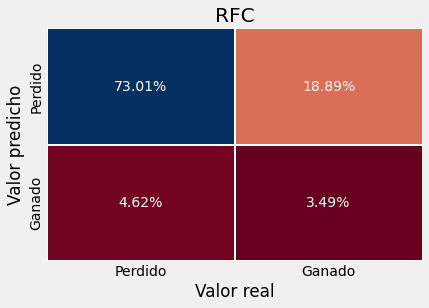

In [40]:
sns.heatmap(rfc_cm, annot=True, cmap='RdBu', cbar=False, fmt='.2%', linewidths=1.5)
plt.title('RFC')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.savefig('./images/rfc-cm.png', dpi=200, bbox_inches='tight')
plt.show()
# plt.

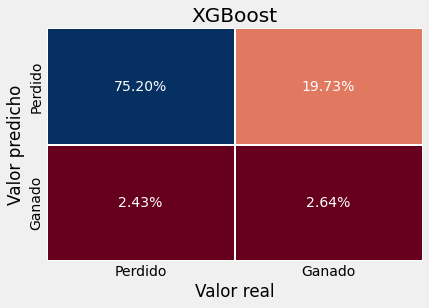

In [41]:
sns.heatmap(xgb_cm, annot=True, cmap='RdBu', cbar=False, fmt='.2%', linewidths=1.5)
plt.title('XGBoost')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.savefig('./images/xgb-cm.png', dpi=200, bbox_inches='tight')
plt.show()
# plt.

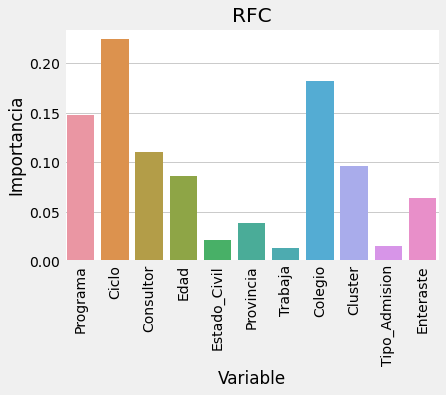

In [42]:
importancia = rfc.feature_importances_
variables_x = [i.title() for i in rfc.feature_names_in_]
sns.barplot(x=variables_x, y=importancia)
plt.xticks(rotation=90)
plt.title('RFC')
plt.ylabel('Importancia')
plt.xlabel('Variable')
plt.savefig('./images/rfc-importancia.png', dpi=200, bbox_inches='tight')
plt.show()

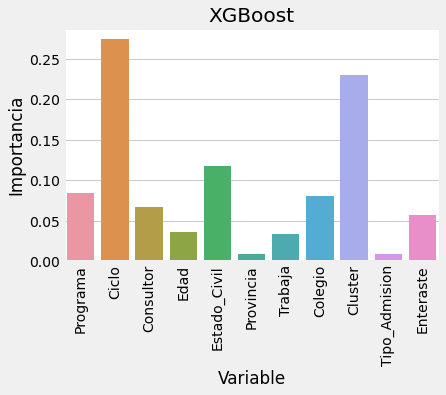

In [43]:
importancia = xgb.feature_importances_
variables_x = [i.title() for i in rfc.feature_names_in_]
sns.barplot(x=variables_x, y=importancia)
plt.xticks(rotation=90)
plt.title('XGBoost')
plt.ylabel('Importancia')
plt.xlabel('Variable')
plt.savefig('./images/xgb-importancia.png', dpi=200, bbox_inches='tight')
plt.show()